<a href="https://colab.research.google.com/github/prantik-pdeb/GSoC2023-ML4SCI_QMLHEP/blob/main/Task_II_Classical_Graph_Neural_Network_(GNN)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task II: Classical Graph Neural Network (GNN) Part

**For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available [here](https://zenodo.org/record/3164691#.ZALnJB9BzIW) with its corresponding description.**


● Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 

● Discuss the resulting performance of the 2 chosen architectures. 


# Dataset Information

X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features are:

a) pt, 

b) rapidity, 

c) azimuthal angle, and 

d) pdgid (particle data group ID)


y: (100000,), an array of labels for the jets where gluon = 0 and quark = 1.

In [1]:
# Install graph-based library
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 43.3 MB/s eta 0:00:00


In [2]:
# Import necessary modules
import torch
import numpy as np
import networkx as nx
import scipy.sparse as sp
import torch.nn as nn
import dgl.nn as dglnn
import torch.nn.functional as F
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from dgl.data.utils import save_graphs, load_graphs
from dgl.nn.pytorch.conv import GraphConv

# Visualization modules
%matplotlib inline
import matplotlib.pyplot as plt

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
dataset = dict(np.load('/content/gdrive/MyDrive/QG_jets.npz'))
X, y = dataset['X'], {'label': torch.tensor(dataset['y']).long()}

In [5]:
X.shape

(100000, 139, 4)

# Graph representation




Mathematically, a graph $\mathcal{G}$ is defined as a tuple of a set of nodes/vertices $V$, and a set of edges/links $E$: $\mathcal{G}=(V,E)$.
Each edge is a pair of two vertices, and represents a connection between them.
For instance, let's look at the following graph:




If we have edge attributes or different categories of edges in a graph, this information can be added to the matrix as well.
For an undirected graph, keep in mind that $A$ is a symmetric matrix ($A_{ij}=A_{ji}$).

# PyTorch Geometric

Implementing graph networks with adjacency matrix is simple and straight-forward but can be computationally expensive for large graphs. Many real-world graphs can reach over 200k nodes, for which adjacency matrix-based implementations fail. There are a lot of optimizations possible when implementing GNNs, and luckily, there exist packages that provide such layers. The most popular packages for PyTorch are [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) and the [Deep Graph Library](https://www.dgl.ai/)

In [6]:
import dgl
import networkx as nx
from dgl.data.utils import save_graphs, load_graphs

# https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

class GenerateGraphs(object):
    def describe(self): return self.__class__.__name__
    def __init__(self, data, connect_style):
        '''
          Args:
            data: np.ndarry
              input data
            connect_style: str
              Type of edge connections
        '''
        self.data = data
        self.label_name = 'label'
        self.feature_name = 'feature'
        self.connect_style = connect_style
        self._current_data = None

    def _assign_node_feature(self, graph):
        ''' Each node presents a b-jet with four momentum and b-tagging score as features.
        '''
        feature_name = 'feature'
        assert(self._current_data is not None)
        graph.ndata[feature_name] = torch.tensor(self._current_data)
        return graph

    def _create_graph(self, ievent: int):
        ''' Create a graph from a jet X [track multiplicity, "4-momentum"], where "4-momentum" is pt, rapidity, azimuthal angle, and pdgid.
            data: https://zenodo.org/record/3164691#.YFeQey1Q0lp
        '''
        self._current_data = self.data[ievent][~np.all(self.data[ievent] == 0, axis=1)]

        ''' Feature preprocessing: Sect 3.1 in https://arxiv.org/pdf/1810.05165.pdf
            centering jets and normalizing pT
            https://energyflow.network/examples/
        '''
        yphi_avg = np.average(self._current_data[:,1:3], weights=self._current_data[:,0], axis=0)
        self._current_data[:,1:3] -= yphi_avg
        self._current_data[:, 0] /= np.sum(self._current_data[:, 0])

        ''' - Sort by pT (0th column) '''
        self._current_data = self._current_data[self._current_data[:,0].argsort()][::-1].copy()

        ''' Construct a graph '''
        n_nodes = self._current_data.shape[0] # track multiplicity
        if self.connect_style == 'bifully':
            ''' Option 1: Fully connected graph '''
            g = nx.complete_graph(n_nodes)
            graph = dgl.from_networkx(g)
        else:
            ''' Option 2: Bi-directional connection in adjacent track in pT or eta or phi'''
            pt_order = self._current_data[:,0].argsort()[::-1]
            rapidity_order = self._current_data[:,1].argsort()[::-1]
            eta_order = self._current_data[:,2].argsort()[::-1]

            if self.connect_style == 'biadj_pt_y_phi':
                in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ], eta_order[1: ]))
            elif self.connect_style == 'biadj_pt_y':
                in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ]))
            elif self.connect_style == 'biadj_pt_phi':
                in_node  = np.concatenate((pt_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((pt_order[1: ], eta_order[1: ]))
            elif self.connect_style == 'biadj_y_phi':
                in_node  = np.concatenate((rapidity_order[:-1], eta_order[:-1]))
                out_node = np.concatenate((rapidity_order[1: ], eta_order[1: ]))

            g = dgl.graph(( in_node, out_node), num_nodes=n_nodes)
            g = dgl.add_reverse_edges(g)
            graph = dgl.add_self_loop(g)


        ''' Assign node feature using "current data" '''
        graph = self._assign_node_feature(graph)

        return graph.int() # 32-bit integers for node and edge IDs to reduce memory

    def create_graphs(self, stop=None):
        ''' Create all graphs for all events.
        '''

        ''' PDGid to small float dictionary https://github.com/pkomiske/EnergyFlow/blob/master/energyflow/utils/data_utils.py#L188 '''
        PID2FLOAT_MAP = {22: 0,
                    211: .1, -211: .2,
                    321: .3, -321: .4,
                    130: .5,
                    2112: .6, -2112: .7,
                    2212: .8, -2212: .9,
                    11: 1.0, -11: 1.1,
                    13: 1.2, -13: 1.3,
                    0: 0,}
        for pid in np.unique(self.data[:, :, 3].flatten()):
            np.place(self.data[:, :, 3], self.data[:, :, 3] == pid, PID2FLOAT_MAP[pid])

        graphs = []
        n_graphs = min(stop, self.data.shape[0]) if stop else self.data.shape[0]
        
        for i in range(n_graphs):
            if i % 1000 == 0:
                print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', f'\033[92mCreated {self.connect_style} graphs:\033[0m'.rjust(40, ' '),  i, '/', n_graphs)
            graph = self._create_graph(i)
            graphs.append(graph)
        return graphs

In [7]:
# Connecting the nodes if they are adjacent
generator = GenerateGraphs(X, connect_style='biadj_pt_y_phi')
graphs = generator.create_graphs()
graph_file_name = 'QG_jets_{connection}.bin'
save_graphs(graph_file_name, graphs, y)

2023-04-01 17:44:11 [INFO]  Created biadj_pt_y_phi graphs: 0 / 100000
2023-04-01 17:44:12 [INFO]  Created biadj_pt_y_phi graphs: 1000 / 100000
2023-04-01 17:44:13 [INFO]  Created biadj_pt_y_phi graphs: 2000 / 100000
2023-04-01 17:44:14 [INFO]  Created biadj_pt_y_phi graphs: 3000 / 100000
2023-04-01 17:44:15 [INFO]  Created biadj_pt_y_phi graphs: 4000 / 100000
2023-04-01 17:44:16 [INFO]  Created biadj_pt_y_phi graphs: 5000 / 100000
2023-04-01 17:44:17 [INFO]  Created biadj_pt_y_phi graphs: 6000 / 100000
2023-04-01 17:44:18 [INFO]  Created biadj_pt_y_phi graphs: 7000 / 100000
2023-04-01 17:44:20 [INFO]  Created biadj_pt_y_phi graphs: 8000 / 100000
2023-04-01 17:44:21 [INFO]  Created biadj_pt_y_phi graphs: 9000 / 100000
2023-04-01 17:44:22 [INFO]  Created biadj_pt_y_phi graphs: 10000 / 100000
2023-04-01 17:44:23 [INFO]  Created biadj_pt_y_phi graphs: 11000 / 100000
2023-04-01 17:44:25 [INFO]  Created biadj_pt_y_phi graphs: 12000 / 100000
2023-04-01 17:44:26 [INFO]  Created biadj_pt_y_phi 

In [8]:
def plot_graph(graph):
    print('Number of nodes and edges: {} / {}'.format(graph.number_of_nodes(), graph.number_of_edges()))
    nx.draw(graph.to_networkx(), with_labels=True, node_color=[[.5, .5, .5]])
    plt.show()

Number of nodes and edges: 18 / 120


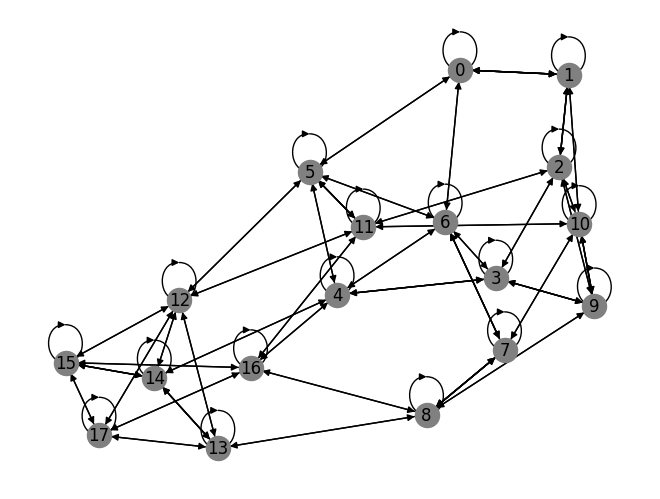

In [9]:
# Graph visualization example-1
plot_graph(graphs[0])

Number of nodes and edges: 17 / 113


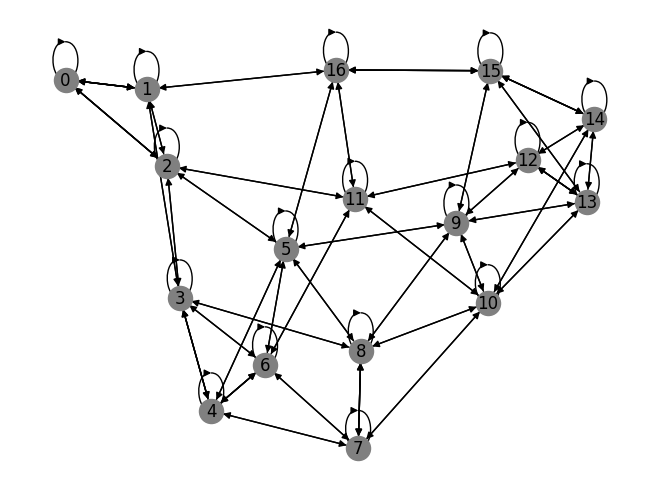

In [10]:
# Graph visualization example-2
plot_graph(graphs[1])

# Preapring dataset train, test and validation split

Here spliting ratio is:

train : test : validation = 7:2:1 with batch size = 1.

In [11]:
#Dataset train, test valodation split
train_size = int(len(graphs) * 0.7)
val_size = int(len(graphs) * 0.2)
test_size = len(graphs) - train_size - val_size

dataset = list(zip(graphs, y['label']))
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_size, val_size, test_size))

#batch size =1
train_dataloader = dgl.dataloading.GraphDataLoader(train_dataset, batch_size = train_size, drop_last=False, shuffle=True)
val_dataloader = dgl.dataloading.GraphDataLoader(val_dataset, batch_size = val_size, drop_last=False, shuffle=False)
test_dataloader = dgl.dataloading.GraphDataLoader(test_dataset, batch_size = test_size, drop_last=False, shuffle=False)

print('Train size: ', train_size)
print('Validation size: ', val_size)
print('Test size: ', test_size)

Train size:  70000
Validation size:  20000
Test size:  10000


# Graph Neural Network(GNN)

GNN when we really mean a layer from a GNN. Most GNNs implement a specific layer that can deal with graphs, and so usually we are only concerned with this layer. An example of a simple layer for a GNN:

\begin{equation}
f_k = \sigma\left( \sum_i \sum_j v_{ij}w_{jk}  \right)
\end{equation}

This equation shows that we first multiply every node ($v_{ij}$) feature by trainable weights $w_{jk}$, sum over all node features, and then apply an activation. This will yield a single feature vector for the graph. This is equation permutation equivariant because the node index in our expression is index $i$ which can be re-ordered without affecting the output.

In [12]:
class GNNmodel(nn.Module):
    def __init__(self, module, in_features, hidden_features, out_features, name='GNN'):
        super().__init__()
        
        self.name = name

        if module.lower() == 'sage':
            # from dgl.nn import SAGEConv
            self.module = SAGE(in_features, hidden_features, out_features)
        elif module.lower() == 'gat':
            # from dgl.nn import GATConv
            self.module = GAT(in_features, hidden_features, out_features)
        elif module.lower() == 'agnnconv':
            # from dgl.nn import AGNNConv
            self.module = AGNNConv()
        elif module.lower() == 'sgc':
            # from dgl.nn import SGConv
            self.module = SGC(in_features, hidden_features, out_features)
        elif module.lower() == 'gcn':
            self.module = GCN(in_features, hidden_features, out_features)
        else:
            assert False, module + ' is not supported'

        # self.pred = MLPPredictor(out_features, 1)

    def forward(self, g, x):
        h = self.module(g, x)
        return torch.squeeze(h) #self.pred(g, h)

# Graph Attention Network(GAT)

[**Attention**](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#What-is-Attention?) concept can be similarly applied to graphs, one of such is the Graph Attention Network called GAT, proposed by Velickovic et al., 2017. 

The graph attention layer creates a message for each node using a linear layer/weight matrix. For the attention part, it uses the message from the node itself as a query, and the messages to average as both keys and values (note that this also includes the message to itself). The score function $f_{attn}$ is implemented as a one-layer MLP which maps the query and key to a single value.

$h_i$ and $h_j$ are the original features from node $i$ and $j$ respectively, and represent the messages of the layer with $\mathbf{W}$ as weight matrix. $\mathbf{a}$ is the weight matrix of the MLP, which has the shape $[1,2\times d_{\text{message}}]$, and $\alpha_{ij}$ the final attention weight from node $i$ to $j$. The calculation can be described as follows:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)\right)}$$

The operator $||$ represents the concatenation, and $\mathcal{N}_i$ the indices of the neighbors of node $i$.

We can see that without the non-linearity, the attention term with $h_i$ actually cancels itself out, resulting in the attention being independent of the node itself. Hence, we would have the same issue as the GCN of creating the same output features for nodes with the same neighbors. This is why the LeakyReLU is crucial and adds some dependency on $h_i$ to the attention. 

Once we obtain all attention factors, we can calculate the output features for each node by performing the weighted average:

$$h_i'=\sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}h_j\right)$$

$\sigma$ is another non-linearity, as in the GCN layer.

In [13]:
class GAT(nn.Module):
    ''' Two layers of Graph Attention Network.
        https://docs.dgl.ai/api/python/nn.pytorch.html#gatconv
    '''
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        # input shape = (nodes, features=in_feats); output shape = (nodes, num_head, hid_feats)
        self.gatconv1 = dglnn.GATConv(in_feats, hid_feats, num_heads=2)
        # input shape = (nodes, hid_feats * num_heads_previous_layer); output shape = (nodes, num_head, out_feats)
        self.gatconv2 = dglnn.GATConv(hid_feats * 2, out_feats, num_heads=1)

    def forward(self, graph, inputs):
        # input shape = (nodes , features)
        # print('inputs', inputs.shape, inputs)
        h = self.gatconv1(graph, inputs)
        # here h shape = (nodes, num_head, hid_feats)
        # print('h1', h.shape, h)
        ''' Reshape h to flatten the num_heads '''
        # here h shape = (nodes, num_head * hid_feats)
        h = h.reshape(h.shape[0], np.prod(h.shape[1:]))
        # print('h2', h.shape, h)
        h = self.gatconv2(graph, h)
        # print('h3', h.shape, h)

        graph.ndata['tmp_feature'] = h
        h = dgl.mean_nodes(graph, 'tmp_feature')
        # print('h4', h.shape, h)
        h = torch.sigmoid(h)
        h = torch.squeeze(h)
        # print('h9', h.shape, h)
        return h

class AGNNConv(nn.Module):
    ''' Graph Attention Network.
        https://docs.dgl.ai/api/python/nn.pytorch.html#agnnconv
    '''
    def __init__(self):
        super().__init__()

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = AGNNConv()(graph, inputs)
        h = torch.sigmoid(h)
        return h

# Graph Convolution Network(GCN)

Graph Convolutional Networks(GCN) have been introduced by Kipf et al.
in 2016 at the University of Amsterdam.

GCNs are similar to convolutions in images in the sense that the "filter" parameters are typically shared over all locations in the graph.
At the same time, GCNs rely on message passing methods, which means that vertices exchange information with the neighbors,
and send "messages" to each other.


As the number of messages vary across nodes, we need an operation that works for any number.
Hence, the usual way to go is to sum or take the mean.
Given the previous features of nodes $H^{(l)}$, the GCN layer is defined as follows:

$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

$W^{(l)}$ is the weight parameters with which we transform the input features into messages ($H^{(l)}W^{(l)}$).
To the adjacency matrix $A$ we add the identity matrix so that each node sends its own message also to itself:
$\hat{A}=A+I$.
Finally, to take the average instead of summing, we calculate the matrix $\hat{D}$ which is a diagonal
matrix with $D_{ii}$ denoting the number of neighbors node $i$ has.
$\sigma$ represents an arbitrary activation function, and not necessarily the sigmoid (usually a ReLU-based
activation function is used in GNNs).

In [14]:
class GCN(nn.Module):
    ''' Graph Convolutional Network
        https://docs.dgl.ai/en/0.4.x/tutorials/basics/4_batch.html#graph-classification-tutorial
        https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/1_gcn.html
    '''
    def __init__(self, in_dim, hidden_dim, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, out_feats)
        self.bn1 = nn.BatchNorm1d(num_features=hidden_dim)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_dim)
        self.bn3 = nn.BatchNorm1d(num_features=out_feats)

    def forward(self, graph, h):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        # h = graph.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.bn1(self.conv1(graph, h)))
        h = F.relu(self.bn2(self.conv2(graph, h)))
        h = F.relu(self.bn3(self.conv3(graph, h)))
        graph.ndata['tmp_feature'] = h
        h = dgl.mean_nodes(graph, 'tmp_feature')
        # Calculate graph representation by averaging all the node representations.
        h = torch.sigmoid(h)
        h = (h-0.5) * 2
        return h

In [15]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



In [16]:
# define training loop
def train(model, optimizer, epochs=100, loss_func=nn.MSELoss()):
  epoch_losses = {'train': [], 'val': []}
  for epoch in range(epochs):
      train_loss = 0
      for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
          node_features = batched_graph.ndata['feature']
          pred = model(batched_graph, node_features.float())
          loss = loss_func(pred, labels.float())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.detach().item()

      # The loss per epoch for all batch is the average of losses per batch in this epoch 
      train_loss /= (ibatch + 1)

      # Store loss per epoch 
      epoch_losses['train'].append(train_loss)

      # Evaluate validation loss
      for ibatch, (batched_graph, labels) in enumerate(val_dataloader):
          node_features = batched_graph.ndata['feature']
          pred = model(batched_graph, node_features.float())
          val_loss = loss_func(pred, labels.float()).detach().item()
          epoch_losses['val'].append(val_loss)
          assert(ibatch == 0)

      print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', '\033[92mepoch, loss, val_loss:\033[0m'.rjust(40, ' '),  epoch+1, '|', train_loss, '|', val_loss)

      # Early stopping
      early_stopping = EarlyStopping(patience=10, verbose=False, path='{}.checkpoint'.format(model.name))
      # early_stopping needs the validation loss to check if it is decreasing, 
      # and if it is, it will make a checkpoint of the current model
      early_stopping(val_loss, model)

      if early_stopping.early_stop:
          print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', '\033[92mepoch, loss, val_loss:\033[0m'.rjust(40, ' '),  epoch+1, '|', train_loss, '|', val_loss)
          print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '\033[92m[INFO]\033[0m', '\033[92mEarly stop at:\033[0m'.rjust(40, ' '),  epoch)
          break
  return epoch_losses

In [17]:
 # define test loop
 def test(model, loss_func=nn.MSELoss()):
    epoch_losses = {'test': []}
    with torch.no_grad():
        ''' Final Evaluate train loss '''
        train_pred = []
        train_labels = []
        for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            # print('zhangr train pred', pred.shape, pred)
            # print('zhangr train labels', labels.shape, labels)
            train_pred.append(pred)
            train_labels.append(labels)
        train_pred = torch.cat(train_pred).numpy()
        train_labels = torch.cat(train_labels).numpy()

        ''' Final Evaluate val loss '''
        val_pred = []
        val_labels = []
        for ibatch, (batched_graph, labels) in enumerate(train_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            val_pred.append(pred)
            val_labels.append(labels)
            assert(ibatch == 0)
        val_pred = torch.cat(val_pred).numpy()
        val_labels = torch.cat(val_labels).numpy()


        ''' Evaluate test loss '''
        test_pred = []
        test_labels = []
        for ibatch, (batched_graph, labels) in enumerate(test_dataloader):
            node_features = batched_graph.ndata['feature']
            pred = model(batched_graph, node_features.float()).detach()
            test_loss = loss_func(pred, labels.float()).detach().item()
            epoch_losses['test'].append(test_loss)
            test_pred.append(pred)
            test_labels.append(labels)
            assert(ibatch == 0)
        test_pred = torch.cat(test_pred).numpy()
        test_labels = torch.cat(test_labels).numpy()
    return epoch_losses, train_pred, train_labels, val_pred, val_labels, test_pred, test_labels

# GAT - Implemenatuions and Result

In [18]:
hidden_features, out_features = 9, 1 # 2 = classifier predict
torch.manual_seed(0)
# create the model
gat_model = GNNmodel('GAT', graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features, name='GAT')
print('Node feature dimension evolution {}->{}->{}'.format(graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features))

Node feature dimension evolution 4->9->1


In [19]:
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.1)

In [20]:
losses = train(gat_model, optimizer)

2023-04-01 17:46:28 [INFO]          epoch, loss, val_loss: 1 | 0.2505398094654083 | 0.28700774908065796
2023-04-01 17:46:39 [INFO]          epoch, loss, val_loss: 2 | 0.28657957911491394 | 0.24965544044971466
2023-04-01 17:46:49 [INFO]          epoch, loss, val_loss: 3 | 0.2495894879102707 | 0.2526317238807678
2023-04-01 17:46:59 [INFO]          epoch, loss, val_loss: 4 | 0.2528746724128723 | 0.25773581862449646
2023-04-01 17:47:08 [INFO]          epoch, loss, val_loss: 5 | 0.2580465078353882 | 0.25153687596321106
2023-04-01 17:47:19 [INFO]          epoch, loss, val_loss: 6 | 0.2517639994621277 | 0.24568906426429749
2023-04-01 17:47:29 [INFO]          epoch, loss, val_loss: 7 | 0.24576687812805176 | 0.2461247593164444
2023-04-01 17:47:39 [INFO]          epoch, loss, val_loss: 8 | 0.24605178833007812 | 0.24723130464553833
2023-04-01 17:47:49 [INFO]          epoch, loss, val_loss: 9 | 0.2470778226852417 | 0.24290132522583008
2023-04-01 17:47:59 [INFO]          epoch, loss, val_loss: 10 |

In [21]:
# load the last checkpoint with the best model.
gat_model.load_state_dict(torch.load(gat_model.name+'.checkpoint'))
# save the model
torch.save(gat_model, gat_model.name)

In [22]:
test_losses, train_pred, train_labels, val_pred, val_labels, test_pred, test_labels = test(gat_model)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

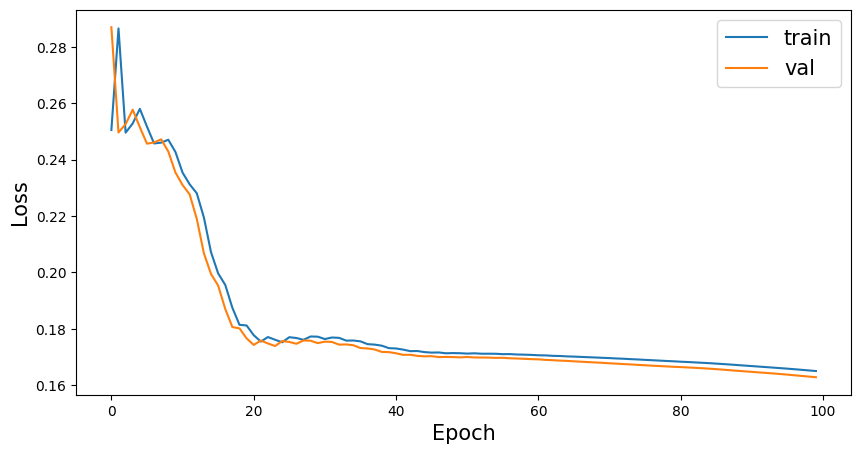

In [23]:
# Plot the loss over time
def plot_loss(*losses, labels=None):
    plt.clf()
    fig = plt.figure(figsize=(10, 5))
    for loss in losses:
        plt.plot(loss)
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    if labels:
      plt.legend(labels, loc='upper right', fontsize=15)
    return plt


plot_loss(losses['train'], losses['val'], labels=['train', 'val'])

# GCN - Implemenatuions and Result

In [24]:
hidden_features, out_features = 9, 1 # 2 = classifier predict
torch.manual_seed(0)
# create the model
gcn_model = GNNmodel('GCN', graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features, name='GAT')
print('Node feature dimension evolution {}->{}->{}'.format(graphs[0].ndata[list(graphs[0].ndata.keys())[0]].shape[1], hidden_features, out_features))

Node feature dimension evolution 4->9->1


In [25]:
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.1)

In [26]:
losses_2 = train(gcn_model, optimizer)

2023-04-01 18:03:34 [INFO]          epoch, loss, val_loss: 1 | 0.3443197011947632 | 0.2831132709980011
2023-04-01 18:03:41 [INFO]          epoch, loss, val_loss: 2 | 0.28157418966293335 | 0.21116183698177338
2023-04-01 18:03:48 [INFO]          epoch, loss, val_loss: 3 | 0.21074998378753662 | 0.19092516601085663
2023-04-01 18:03:56 [INFO]          epoch, loss, val_loss: 4 | 0.19129684567451477 | 0.18269340693950653
2023-04-01 18:04:03 [INFO]          epoch, loss, val_loss: 5 | 0.18367820978164673 | 0.17287427186965942
2023-04-01 18:04:10 [INFO]          epoch, loss, val_loss: 6 | 0.17429222166538239 | 0.16451036930084229
2023-04-01 18:04:17 [INFO]          epoch, loss, val_loss: 7 | 0.16635699570178986 | 0.15986575186252594
2023-04-01 18:04:25 [INFO]          epoch, loss, val_loss: 8 | 0.16191856563091278 | 0.15790952742099762
2023-04-01 18:04:32 [INFO]          epoch, loss, val_loss: 9 | 0.16005322337150574 | 0.15702763199806213
2023-04-01 18:04:39 [INFO]          epoch, loss, val_loss

In [27]:
# load the last checkpoint with the best model.
gcn_model.load_state_dict(torch.load(gcn_model.name+'.checkpoint'))
# save the model
torch.save(gcn_model, gcn_model.name)

In [28]:
test_losses2, train_pred2, train_labels2, val_pred2, val_labels2, test_pred2, test_labels2 = test(gcn_model)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

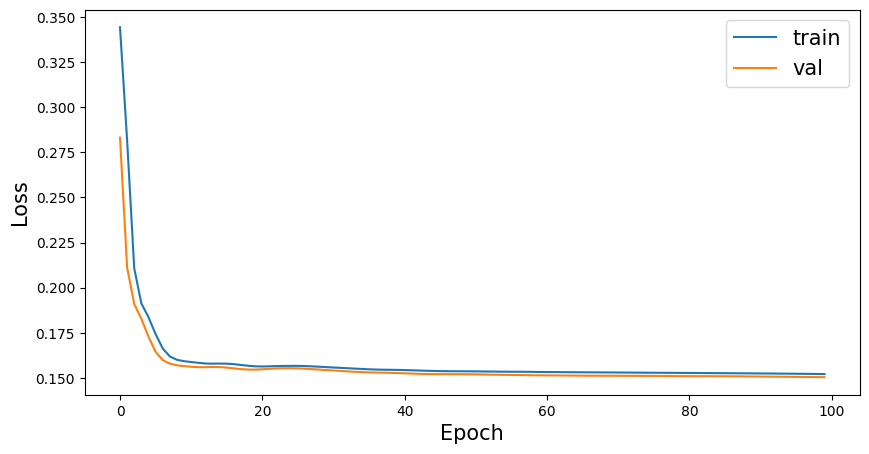

In [31]:
plot_loss(losses_2['train'], losses_2['val'], labels=['train', 'val'])

Here I am using two most popular Graph based architectures:-



1.   Graph Attention Network(GAT)
2.   Graph Convolution Network(GCN)



# Reference:

1. Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P., &amp; Bengio, Y. (2018, February 4). Graph attention networks. arXiv.org. Retrieved April 19, 2022, from https://arxiv.org/abs/1710.10903 

2. Kipf, T. N., &amp; Welling, M. (2017, February 22). Semi-supervised classification with graph Convolutional Networks. arXiv.org. Retrieved April 19, 2022, from https://arxiv.org/abs/1609.02907 

3. Berg, R. van den, Kipf, T. N., &amp; Welling, M. (2017, October 25). Graph convolutional matrix completion. arXiv.org. Retrieved April 19, 2022, from https://arxiv.org/abs/1706.02263 

4. Graph neural networks: A review of methods and applications. (n.d.). Retrieved April 19, 2022, from https://arxiv.org/ftp/arxiv/papers/1812/1812.08434.pdf 

5. Cohen, T., &amp; Welling, M. (2016, June 11). Group equivariant Convolutional Networks. PMLR. Retrieved April 19, 2022, from http://proceedings.mlr.press/v48/cohenc16.html 


6. Machine Learning with Graphs | Stanford Online. CS224W | Home. (n.d.). Retrieved April 19, 2022, from http://web.stanford.edu/class/cs224w/ 







